In [1]:
import pandas as pd
import numpy as np
import torch
import pickle
import matplotlib.pyplot as plt

from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from empath import Empath

In [2]:
# Check if GPU is available
'cuda' if torch.cuda.is_available() else 'cpu'

'cuda'

In [3]:
# Load your data
file_path = 'C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/suomi24/Data/suomi24-processed.csv'
df = pd.read_csv(file_path)

# Define the hypotheses and encode them
hypotheses = [
    "Personal experiences with surveillance cameras significantly shape people's views on public monitoring.",
    "Attitudes toward surveillance cameras vary significantly depending on their placement in different settings, such as shopping areas, residential blocks, and workplaces.",
    "There are common technical complaints about surveillance cameras, and people suggest specific enhancements to address these issues.",
    "Surveillance cameras make people feel more secure rather than feeling watched.",
    "There is a noticeable relationship between the density of surveillance cameras in an area and public opinion regarding their presence."
]

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the SentenceTransformer model and send it to the device
model = SentenceTransformer("Snowflake/snowflake-arctic-embed-s").to(device)
hypothesis_embeddings = model.encode(hypotheses, convert_to_tensor=True, device=device).cpu()

# Save hypothesis embeddings
with open('C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/suomi24/models/hypothesis-embeddings.pkl', 'wb') as f:
    torch.save(hypothesis_embeddings, f)

You try to use a model that was created with version 2.7.0.dev0, however, your version is 2.7.0. This might cause unexpected behavior or errors. In that case, try to update to the latest version.



C:\Users\fahad\AppData\Roaming\Python\Python311\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [5]:
# Load saved embeddings
hypothesis_embeddings = torch.load('C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/suomi24/models/hypothesis-embeddings.pkl')

In [4]:
column = 'thread_text_processed'

In [12]:
texts = df[column].tolist()

# Generate embeddings in batches
batch_size = 10000
embeddings = []

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Load the SentenceTransformer model and send it to the device
model = SentenceTransformer("Snowflake/snowflake-arctic-embed-s").to(device)

for i in tqdm(range(0, len(texts), batch_size), desc="Processing batches"):
    batch_texts = texts[i:i + batch_size]
    batch_embeddings = model.encode(batch_texts, convert_to_tensor=True, device=device).cpu()
    embeddings.append(batch_embeddings)

# Concatenate all batches
embeddings = torch.cat(embeddings, dim=0)

# Save text embeddings
with open(f'C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/suomi24/models/{column}-embeddings.pkl', 'wb') as f:
    torch.save(embeddings, f)

You try to use a model that was created with version 2.7.0.dev0, however, your version is 2.7.0. This might cause unexpected behavior or errors. In that case, try to update to the latest version.



C:\Users\fahad\AppData\Roaming\Python\Python311\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Processing batches: 100%|██████████| 22/22 [2:37:58<00:00, 430.85s/it]  


In [8]:
# Load saved embeddings
embeddings = torch.load(f'C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/suomi24/models/{column}-embeddings.pkl')

In [5]:
# Initialize Empath
empath = Empath()
# Function to calculate empath categories
def get_empath_categories(text):
    categories = empath.analyze(text)
    return np.array([categories[cat] for cat in empath.cats.keys()])

In [6]:
# Calculate empath embeddings for hypotheses
hypothesis_empath_embeddings = np.array([get_empath_categories(hypothesis) for hypothesis in hypotheses])

# Save hypothesis empath embeddings
with open('C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/suomi24/models/hypothesis_empath_embeddings.pkl', 'wb') as f:
    pickle.dump(hypothesis_empath_embeddings, f)

In [7]:
# Calculate empath embeddings for the dataset
empath_embeddings = []
tqdm.pandas(desc="Processing Empath Embeddings")
for empath_embedding in df['thread_text_processed'].progress_apply(lambda x: get_empath_categories(x)):
    empath_embeddings.append(empath_embedding)

# Save the empath embeddings to a file
with open(f'C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/suomi24/models/{column}-empath_embeddings.pkl', 'wb') as f:
    pickle.dump(empath_embeddings, f)

Processing Empath Embeddings: 100%|██████████| 218001/218001 [26:32<00:00, 136.88it/s]


In [ ]:
# Load saved embeddings
hypothesis_empath_embeddings = torch.load(f'C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/suomi24/models/hypothesis_empath_embeddings.pkl')

empath_embeddings = torch.load(f'C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/suomi24/models/{column}-empath_embeddings.pkl')

In [13]:
# Function to assign hypothesis based on both text and empath embeddings
def assign_hypothesis(text_embedding, empath_embedding, margin=0.03):
    text_similarities = cosine_similarity([text_embedding], hypothesis_embeddings).flatten()
    sorted_similarities = np.sort(text_similarities)[::-1]
    
    if sorted_similarities[0] - sorted_similarities[1] <= margin:
        empath_similarities = cosine_similarity([empath_embedding], hypothesis_empath_embeddings).flatten()
        combined_similarities = (text_similarities + empath_similarities) / 2
        return np.argmax(combined_similarities)
    return np.argmax(text_similarities)

In [21]:
# Assign hypotheses
tqdm.pandas(desc="Assigning Hypotheses")
hypothesis_labels = {i: f'H{i}' for i in range(len(hypotheses))}
df['hypothesis'] = [hypothesis_labels[assign_hypothesis(embeddings[i], empath_embeddings[i])] for i in tqdm(range(len(embeddings)))]


100%|██████████| 218001/218001 [02:29<00:00, 1462.88it/s]


In [22]:
df

,msg_type,datetime,title,thread_id,comment_id,topic_name_top,topic_name_leaf,thread_text,title_processed,thread_text_processed,combined_processed,hypothesis
0,thread_start,10/21/2008 15:10,2008,6382354,0,Groups,40 plus,"but despised and questioned yes. 2008 Well, we...",NaN,but despised and questioned yes well we thoug...,but despised and questioned yes well we thou...,H2
1,comment,10/21/2008 16:34,2008,6382354,33460404,Groups,40 plus,Orwell was a seer. In '84 the world didn't exa...,NaN,orwell was a seer in the world did not exactl...,orwell was a seer in the world did not exact...,H4
2,comment,3/19/2016 9:40,- I don't know. - What's the payoff?,14185813,83782764,Hobbies,Electronics,which did not protect the car owner from the r...,i do not know what is the payoff,which did not protect the car owner from the r...,i do not know what is the payoff which did n...,H1
3,comment,3/25/2016 23:48,- I don't know. - What's the payoff?,14185813,83896363,Hobbies,Electronics,"the cashier will have a ""card reported as miss...",i do not know what is the payoff,the cashier will have a card reported as missi...,i do not know what is the payoff the cashier...,H2
4,comment,4/11/2016 23:06,- I don't know. - What's the payoff?,14185813,84156873,Hobbies,Electronics,but do those only Mastercard Kredit cards with...,i do not know what is the payoff,but do those only mastercard kredit cards with...,i do not know what is the payoff but do thos...,H1
...,...,...,...,...,...,...,...,...,...,...,...,...
217996,comment,3/16/2013 11:54,Localities,11340784,60550054,Localities,Nickel,thank you. Who could make it happen? Camera St...,localities,thank you who could make it happen camera stel...,localities thank you who could make it happen ...,H2
217997,comment,1/16/2015 15:03,Vehicles and transport,13305552,77069109,Vehicles and transport,Public transport,This rave junta now put the lives of possibly ...,vehicles and transport,this rave junta now put the lives of possibly ...,vehicles and transport this rave junta now put...,H0
217998,comment,3/18/2013 13:55,Localities,11340784,60588127,Localities,Nickel,It would be nice to see what's going on there ...,localities,it would be nice to see what is going on there...,localities it would be nice to see what is goi...,H4
217999,comment,3/30/2006 8:55,Localities,2778360,14276358,Localities,Rovaniemi,did not prevent our table from stealing. Its a...,localities,did not prevent our table from stealing its a ...,localities did not prevent our table from stea...,H0


hypothesis
H2    74096
H4    44428
H3    41100
H1    36431
H0    21946
Name: count, dtype: int64


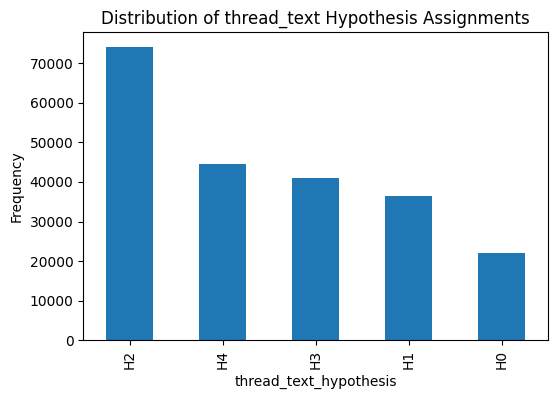

In [24]:
# Optional: Display a histogram of the assigned hypotheses
print(df['hypothesis'].value_counts())
df['hypothesis'].value_counts().plot(kind='bar', figsize=(6,4))
plt.title('Distribution of thread_text Hypothesis Assignments')
plt.xlabel('thread_text_hypothesis')
plt.ylabel('Frequency')
plt.show()

In [23]:
# Save the DataFrame with the hypothesis mapping
df.to_csv('C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/suomi24/Data/suomi24_with_hypotheses.csv', index=False)

In [ ]:
# H0: Personal experiences with surveillance cameras significantly shape people's views on public monitoring.
# H1: Attitudes toward surveillance cameras vary significantly depending on their placement in different settings, such as shopping areas, residential blocks, and workplaces.
# H2: There are common technical complaints about surveillance cameras, and people suggest specific enhancements to address these issues.
# H3: Surveillance cameras make people feel more secure rather than feeling watched.
# H4: There is a noticeable relationship between the density of surveillance cameras in an area and public opinion regarding their presence.